In [4]:
import ipyparallel as ipp
def mpi_example():
    comm = MPI.COMM_WORLD
    return f"Hello World from rank {comm.Get_rank()}. total ranks={comm.Get_size()}"

with ipp.Cluster(engines='mpi', n=4) as rc:
    # get a broadcast_view on the cluster which is best
    # suited for MPI style computation
    view = rc.broadcast_view()
    # run the mpi_example function on all engines in parallel
    r = view.apply_sync(mpi_example)
    # Retrieve and print t

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

Stopping engine(s): 1728599088
engine set stopped 1728599088: {'exit_code': 0, 'pid': 145, 'identifier': 'ipengine-1728599087-hep5-1728599088-17'}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 114, 'identifier': 'ipcontroller-1728599087-hep5-17'}


In [6]:
from mpi4py import MPI
from petsc4py import PETSc
import matplotlib.pyplot as plt
import numpy as np
import pyvista

from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import VTXWriter
from dolfinx.mesh import create_unit_square,create_rectangle,CellType
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction,Measure,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym,
                 SpatialCoordinate, conditional, ge, le)

In [43]:
def run_sim(height=42, length=4.1,T=10,num_steps=2000, file=False):
    mesh = create_rectangle(MPI.COMM_WORLD,[[0,0], [length, height]],[int(length*10),int(height*10)])
    t = 0
    dt = T / num_steps
    
    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)
    
    u = TrialFunction(V)
    v = TestFunction(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)
    
    def walls(x):
        return np.logical_or(np.isclose(x[1], 0), np.isclose(x[1], height))
    
    wall_dofs = locate_dofs_geometrical(V, walls)
    u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    bc_noslip = dirichletbc(u_noslip, wall_dofs, V)
    
    def inflow(x):
        return np.isclose(x[0], 0)
    
    inflow_dofs = locate_dofs_geometrical(Q, inflow)
    bc_inflow = dirichletbc(PETSc.ScalarType(6), inflow_dofs, Q)
    
    def outflow(x):
        return np.isclose(x[0], length)
    
    outflow_dofs = locate_dofs_geometrical(Q, outflow)
    bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)
    bcu = [bc_noslip]
    bcp = [bc_inflow, bc_outflow]
    
    u_n = Function(V)
    u_n.name = "u_n"
    U = 0.5 * (u_n + u)
    n = FacetNormal(mesh)
    f = Constant(mesh, PETSc.ScalarType((0, 0)))
    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(1))
    rho = Constant(mesh, PETSc.ScalarType(1))
    
    # Define strain-rate tensor
    def epsilon(u):
        return sym(nabla_grad(u))
    
    # Define stress tensor
    def sigma(u, p):
        return 2 * mu * epsilon(u) - p * Identity(len(u))
    
    
    # Define the variational problem for the first step
    p_n = Function(Q)
    p_n.name = "p_n"
    F1 = rho * dot((u - u_n) / k, v) * dx
    F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
    F1 += inner(sigma(U, p_n), epsilon(v)) * dx
    F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
    F1 -= dot(f, v) * dx
    a1 = form(lhs(F1))
    L1 = form(rhs(F1))
    
    
    A1 = assemble_matrix(a1, bcs=bcu)
    A1.assemble()
    b1 = create_vector(L1)
    
    # Define variational problem for step 2
    u_ = Function(V)
    a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx)
    L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)
    
    # Define variational problem for step 3
    p_ = Function(Q)
    a3 = form(rho * dot(u, v) * dx)
    L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)
    
    # Solver for step 1
    solver1 = PETSc.KSP().create(mesh.comm)
    solver1.setOperators(A1)
    solver1.setType(PETSc.KSP.Type.BCGS)
    pc1 = solver1.getPC()
    pc1.setType(PETSc.PC.Type.HYPRE)
    pc1.setHYPREType("boomeramg")
    
    # Solver for step 2
    solver2 = PETSc.KSP().create(mesh.comm)
    solver2.setOperators(A2)
    solver2.setType(PETSc.KSP.Type.BCGS)
    pc2 = solver2.getPC()
    pc2.setType(PETSc.PC.Type.HYPRE)
    pc2.setHYPREType("boomeramg")
    
    # Solver for step 3
    solver3 = PETSc.KSP().create(mesh.comm)
    solver3.setOperators(A3)
    solver3.setType(PETSc.KSP.Type.CG)
    pc3 = solver3.getPC()
    pc3.setType(PETSc.PC.Type.SOR)

    if file:
        from pathlib import Path
        folder = Path("results")
        folder.mkdir(exist_ok=True, parents=True)
        vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
        vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4")
        vtx_u.write(t)
        vtx_p.write(t)
    
    def u_exact(x):
        values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = 4 * x[1] * (1.0 - x[1])
        return values
    
    u_ex = Function(V)
    u_ex.interpolate(u_exact)
    
    L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx)
    
    topology, cell_types, geometry = vtk_mesh(V)
    x_coords = geometry[:, 0]
    y_coords = geometry[:, 1]

    fig, ax = plt.subplots()
    plt.xlabel('y')
    plt.ylabel('u_n')
    plt.title('u_n values at different x-coordinates')
    plt.legend()
    
    for i in range(num_steps):
        # Update current time step
        t += dt
    
        # Step 1: Tentative veolcity step
        with b1.localForm() as loc_1:
            loc_1.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        solver1.solve(b1, u_.x.petsc_vec)
        u_.x.scatter_forward()
    
        # Step 2: Pressure corrrection step
        with b2.localForm() as loc_2:
            loc_2.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        solver2.solve(b2, p_.x.petsc_vec)
        p_.x.scatter_forward()
    
        # Step 3: Velocity correction step
        with b3.localForm() as loc_3:
            loc_3.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        solver3.solve(b3, u_.x.petsc_vec)
        u_.x.scatter_forward()
        # Update variable with solution form this time step
        u_n.x.array[:] = u_.x.array[:]
        p_n.x.array[:] = p_.x.array[:]
    
        # print velocity profile
        if (i % 100 == 0) or (i == num_steps - 1):
            plot_para_velo(ax,x_coords, y_coords, u_n, t, geometry)
            a6, a7 = mfl_press(length, mesh, u_n, p_n)
            print(a6, a7)

        if file:
            # Write solutions to file
            vtx_u.write(t)
            vtx_p.write(t)
    
        # Compute error at current time-step
        error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
        error_max = mesh.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
        # Print error only every 20th step and at the last step
        if (i % 20 == 0) or (i == num_steps - 1):
            print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
    # Close xmdf file
    if file:
        vtx_u.close()
        vtx_p.close()
    b1.destroy()
    b2.destroy()
    b3.destroy()
    solver1.destroy()
    solver2.destroy()
    solver3.destroy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(441, 2)
0.16097529432038143 3.073165429488574
Time 0.01, L2-error 7.76e+03, Max error 1.85e+03
Time 0.11, L2-error 7.76e+03, Max error 1.85e+03
Time 0.21, L2-error 7.76e+03, Max error 1.85e+03
Time 0.31, L2-error 7.76e+03, Max error 1.85e+03
Time 0.41, L2-error 7.76e+03, Max error 1.85e+03
(441, 2)
15.468300764441802 3.0731201962673165
Time 0.51, L2-error 7.76e+03, Max error 1.85e+03
Time 0.61, L2-error 7.76e+03, Max error 1.85e+03
Time 0.71, L2-error 7.76e+03, Max error 1.85e+03
Time 0.81, L2-error 7.76e+03, Max error 1.85e+03
Time 0.91, L2-error 7.76e+03, Max error 1.85e+03
(441, 2)
30.137512408661983 3.073091276697757
Time 1.01, L2-error 7.77e+03, Max error 1.85e+03
Time 1.10, L2-error 7.77e+03, Max error 1.85e+03
Time 1.20, L2-error 7.77e+03, Max error 1.85e+03
Time 1.30, L2-error 7.77e+03, Max error 1.85e+03
Time 1.40, L2-error 7.77e+03, Max error 1.85e+03
(441, 2)
44.38799572231482 3.0730599793084377
Time 1.50, L2-error 7.77e+03, Max error 1.85e+03
Time 1.60, L2-error 7.77e+03, 

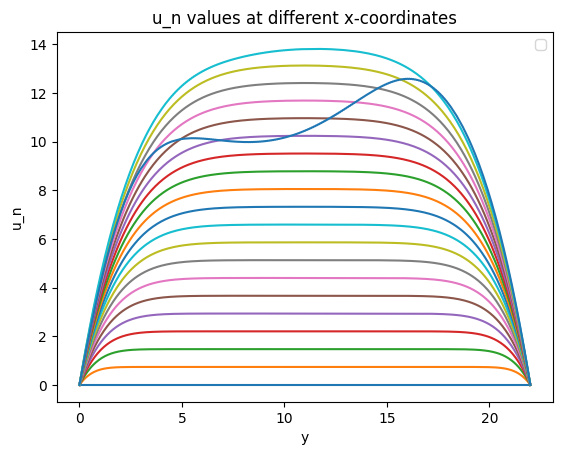

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [42]:
run_sim()

In [34]:
# Get the minimum and maximum x-coordinates of the mesh
def mfl_press(x_max, mesh, u_n, p):    
    # Extract the normal component of velocity (u_x in 2D)
    u_sub = u_n.sub(0)
    
    # Define measures and spatial coordinates
    dx = Measure("dx", domain=mesh)
    x = SpatialCoordinate(mesh)
    x_pos = int(x_max/2)

    slice_condition = conditional(ge(x[0], x_pos - 5e-1), 1.0, 0.0) * conditional(le(x[0], x_pos + 5e-1), 1.0, 0.0)
    # Calculate mass flow rate at the current slice
    mass_flow = assemble_scalar(form(u_sub * slice_condition * dx))
    # Calculate average pressure at the current slice
    pressure_avg = assemble_scalar(form(p * slice_condition * dx)) / assemble_scalar(form(slice_condition * dx))
        
    return mass_flow, pressure_avg

In [36]:
def plot_para_velo(ax,x_coords, y_coords, u_n, t, geometry):
    if MPI.COMM_WORLD.rank == 0:
        u_values = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))
        
        plt.figure(figsize=(10, 6))

        # Find all points with x-coordinate close to x_index
        mask = np.isclose(x_coords, x_coords/2, atol=1e-6)
            
        # Extract y-coordinates and u_values for these points
        y_plot = y_coords[mask]
        u_plot = u_values[mask]
        
        # Sort the points by y-coordinate
        sort_indices = np.argsort(y_plot)
        y_plot = y_plot[sort_indices]
        u_plot = u_plot[sort_indices]
        print(u_plot.shape)
        # Plot u_n values against y-coordinates
        ax.plot( y_plot,u_plot[:,0], label=f'x = {x_coords/2}')
        
        # Save the plot
        #plt.show()        
        #plt.close()
        ax.figure.savefig('u_n_plot_'+str(t)+'.pdf')
        return y_plot,u_plot[:,0]

In [20]:
x_min, x_max = np.min(geometry[:, 0]), np.max(geometry[:, 0])
y_min, y_max = np.min(geometry[:, 1]), np.max(geometry[:, 1])

# Create a regular grid
grid_size = 100  # Adjust this for higher/lower resolution
xi = np.linspace(x_min, x_max, grid_size)
yi = np.linspace(y_min, y_max, grid_size)
xi, yi = np.meshgrid(xi, yi)

# Interpolate your scattered data onto the regular grid
# We'll use the magnitude of the vectors for this example
from scipy.interpolate import griddata
magnitudes = np.linalg.norm(values, axis=1)
zi = griddata((geometry[:, 0], geometry[:, 1]), magnitudes, (xi, yi), method='linear')

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Use imshow to create a color plot
im = ax.imshow(zi, extent=[x_min, x_max, y_min, y_max], origin='lower', 
               cmap='viridis', aspect='auto')

# Add a colorbar
cbar = plt.colorbar(im)
cbar.set_label('Magnitude')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Vector Field Magnitude')

# Save the figure
plt.savefig('matplotlib_imshow.pdf')

# Show the plot
plt.show()

NameError: name 'values' is not defined

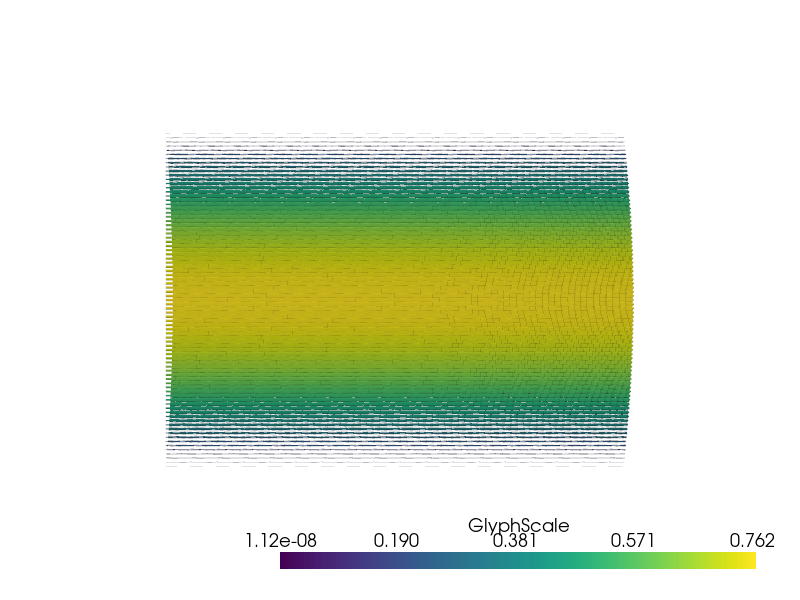

In [12]:
import pyvista
pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.7)

# Create a pyvista-grid for the mesh
#mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
#grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
#plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.window_size = [800, 600]
plotter.set_scale(yscale=4)
plotter.view_xy()
plotter.save_graphic("glyphs2.pdf",title='PyVista Export')
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("velocity_field.pdf")

In [98]:
import codecs, json 

def write_json(it, u, x, filename, exists=True):
    data = pd.DataFrame([it,ux[0],ux[1]], index=['iter','u','x'])
    data = data.to_json(orient='index')
    #all_data.append(data)
    with open(filename, "w") as fp:
        if exists:
            listObj = json.loads(fp)
        else:
            listObj = []
        listObj.append(data)
        data = pd.DataFrame([it,ux[0],ux[1]], index=['iter','u','x'])
        data = data.to_json(path_or_buf=filename,orient='index')

def read_json(file_path):
    obj = codecs.open(file_path, 'r', encoding='utf-8').read()
    json_text = json.loads(obj_text)
    return np.array(json_text)


write_json(1,np.array([['one'],['two']]),np.array([[1,2,3],[1,2,3]]),"all_iterations.json",False)
write_json(2,np.array([['one'],['two']]),np.array([[1,2,3],[1,2,3]]),"all_iterations.json")

TypeError: the JSON object must be str, bytes or bytearray, not TextIOWrapper

In [104]:
import pandas as pd
it = np.array(['one'])
ux = np.array([[1,2,3],[1,2,3]])
filename = "all_iterations.json"
exists = False
#data_old = pd.read_json(path_or_buf=filename,orient='index')
#data = pd.DataFrame([it,ux[0],ux[1]], index=['iter','u','x'])
#data = data.to_json(path_or_buf=filename,orient='index')
with open(filename, "w") as fp:
    listObj = json.load(fp)
    
        

UnsupportedOperation: not readable

In [95]:
print(data)


None


In [87]:
with open(filename, "w") as fp:
    listObj = json.load(fp)

UnsupportedOperation: not readable

In [1]:
import pandas as pd
import sqlite3 as sql

ModuleNotFoundError: No module named 'pandas'

In [11]:
run_sim()

TypeError: create_rectangle_float64(): incompatible function arguments. The following argument types are supported:
    1. create_rectangle_float64(comm: MPICommWrapper, p: list[list[float]], n: list[int], celltype: dolfinx.cpp.mesh.CellType, partitioner: Optional[Callable[[MPICommWrapper, int, dolfinx.cpp.mesh.CellType, dolfinx.cpp.graph.AdjacencyList_int64], dolfinx.cpp.graph.AdjacencyList_int32]], diagonal: dolfinx.cpp.mesh.DiagonalType) -> dolfinx.cpp.mesh.Mesh_float64

Invoked with types: Intracomm, list, list, dolfinx.cpp.mesh.CellType, NoneType, dolfinx.cpp.mesh.DiagonalType